In [1]:
#Importing useful libraries
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import exposure, img_as_uint
import cv2
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

#loading data
dataTrain = nib.load('tr_im.nii.gz')
dataTest = nib.load('val_im.nii.gz')

In [2]:
#function to show n images
def showImages(images, rows, cols):
    plt.figure(figsize = (16,16))
    for i in range (rows*cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title('Lung')
        plt.xticks(())
        plt.yticks(())

## The following code is an adaptation from kaggle Data Science Bowl 2017. Credits to his owner Ankasor user
https://www.kaggle.com/ankasor/improved-lung-segmentation-using-watershed?scriptVersionId=757554

In [3]:
#function to get the images into an numpy array of type int16
#our images are in the HU scale, so its not necessary convert it again!
def getImages(data):
    image = np.stack([data.get_fdata()[:,:,s] for s in range(data.shape[2])])
    image = image.astype(np.int16)
    return np.array(image, dtype=np.int16)

First 25 Train Images
######################################


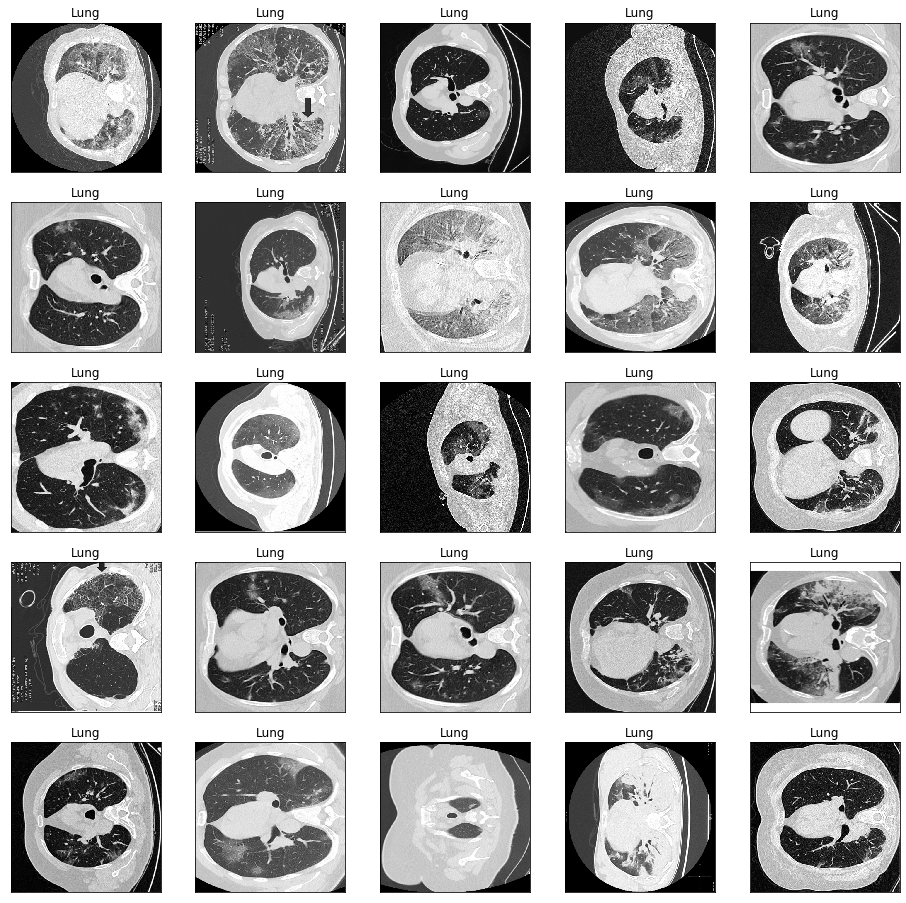

In [4]:
#getting data
train = getImages(dataTrain)
test = getImages(dataTest)
showImages(train[:25],5,5)
print('First 25 Train Images')
print('######################################')

All Test Images
######################################


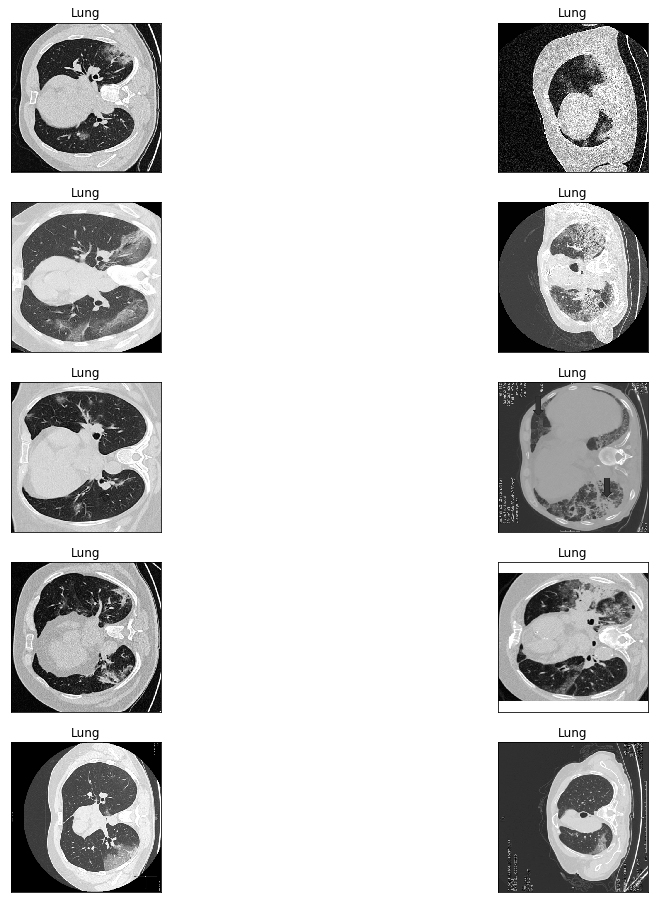

In [5]:
#showing test images
showImages(test[:10],5,2)
print('All Test Images')
print('######################################')

In [6]:
#function to get the lungs and its surroundings (white part wich corresponds to bones or body)
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -300
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

Internal Marker


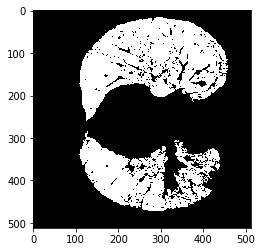

External Marker


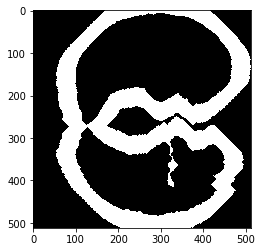

Watershed Marker


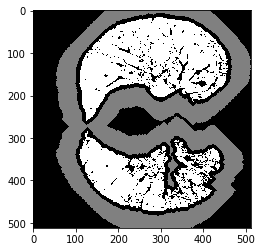

In [7]:
#showing segmented marks
trainLung, trainExternal, trainWatershed = generate_markers(train[1])
print ("Internal Marker")
plt.imshow(trainLung, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(trainExternal, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(trainWatershed, cmap='gray')
plt.show()

In [8]:
#function to do the previous step iteratively
def getAllMarkers(images):
    lung = []
    external = []
    watershed = []
    for i in range(images.shape[0]):
        auxLung, auxExternal, auxWatershed = generate_markers(images[i])
        lung.append(auxLung)
        external.append(auxExternal)
        watershed.append(auxWatershed)
    return lung, external, watershed

First 16 Watershed Train Images
######################################


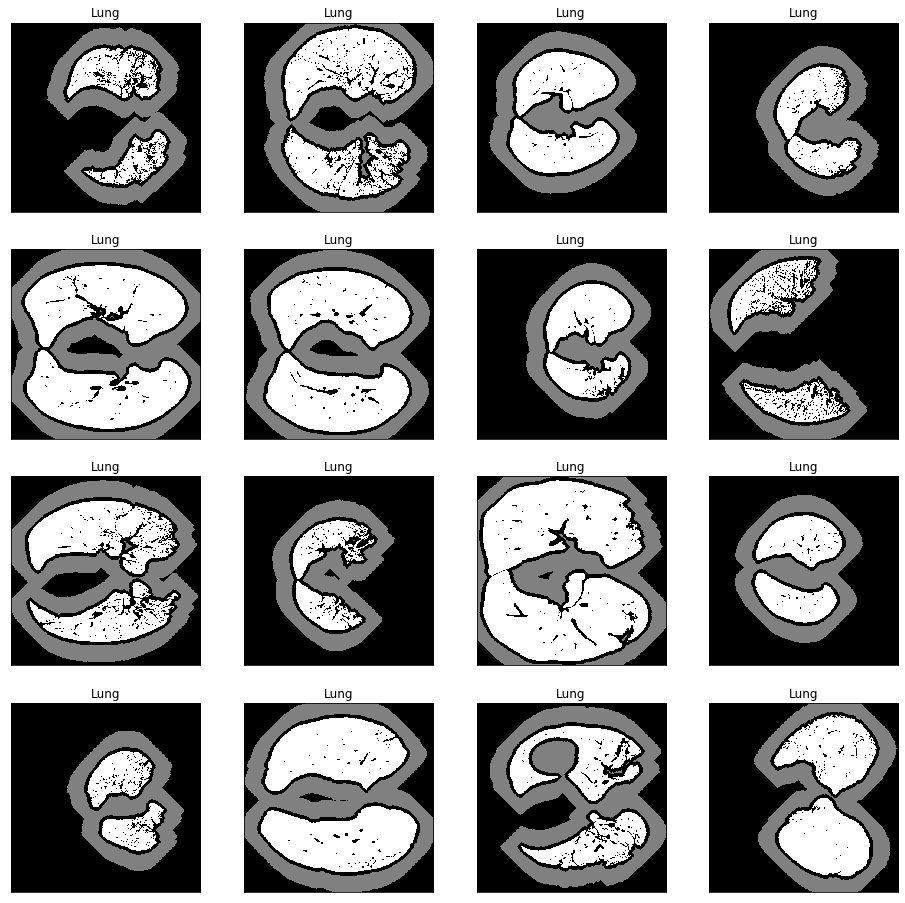

In [9]:
#showing the results for train
trainLung, trainExternal, trainWatershed = getAllMarkers(train)
testLung, testExternal, testWatershed = getAllMarkers(test)
showImages(trainWatershed[:16],4,4)
print('First 16 Watershed Train Images')
print('######################################')

All Watershed Test Images
######################################


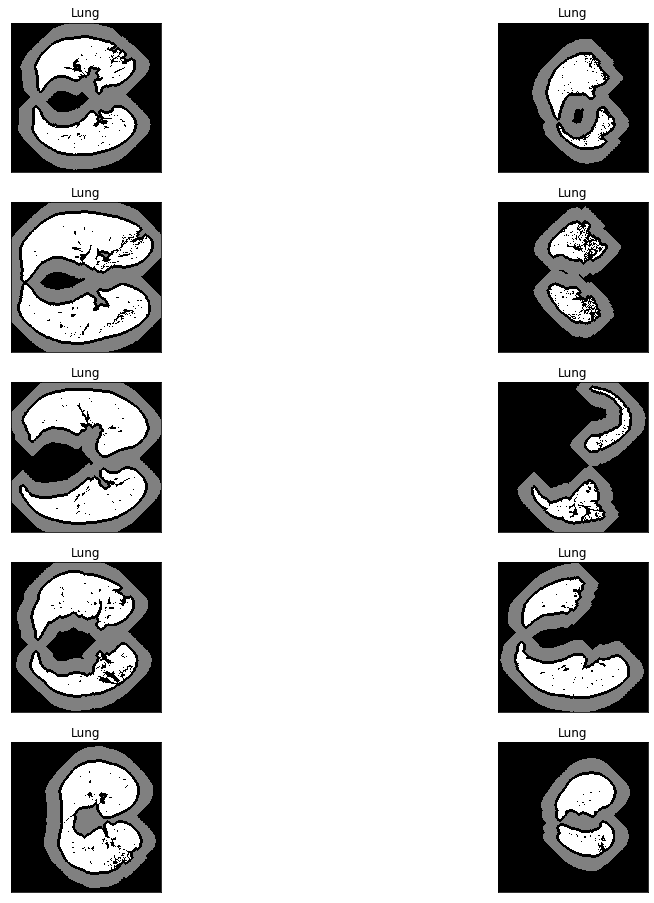

In [10]:
#showing the results for test
showImages(testWatershed[:10],5,2)
print('All Watershed Test Images')
print('######################################')

In [11]:
#function to segment the lungs
def seperate_lungs(image):
    #Creation of the markers as before:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

Sobel Gradient


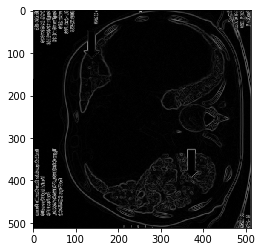

Watershed Image


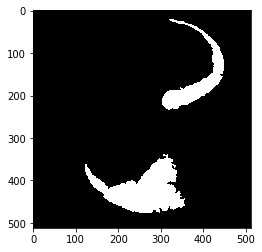

Outline after reinclusion


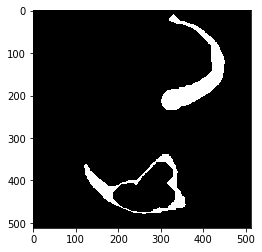

Lungfilter after closing


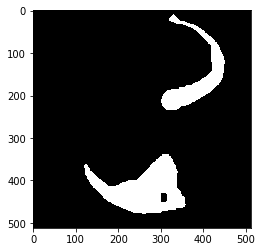

Segmented Lung


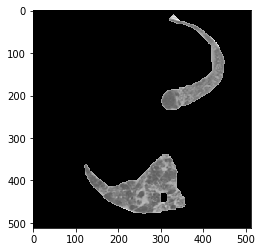

In [12]:
#instanciate the results of funcrion separate_lungs
testSegmented, testLungfilter, testOutline, testWatershed, testSobelGradient, testLung, testExternal, testMarkerWatershed = seperate_lungs(test[5])
#showing results
print ("Sobel Gradient")
plt.imshow(testSobelGradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(testWatershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.imshow(testOutline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.imshow(testLungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.imshow(testSegmented, cmap='gray')
plt.show()

In [13]:
#function to do the previous step iteratively
def segmentLungs(images):
    sobel = []
    segmentedLungs = []
    masks = []
    for i in range(images.shape[0]):
        segmented,lungfilter,Outline,watershed,sobelGradient,lung,external,MarkerWatershed = seperate_lungs(images[i])
        sobel.append(sobelGradient)
        segmentedLungs.append(segmented)
        masks.append(lungfilter)
    return sobel, segmentedLungs, masks

In [14]:
#instanciate the results of funcrion separate_lungs for every image in train set
trainSobel, trainSegmentedLungs, trainMasks = segmentLungs(train)
#instanciate the results of funcrion separate_lungs for every image in test set
testSobel, testSegmentedLungs, testMask = segmentLungs(test)

First 25 Segmented Lungs from Train Images
######################################


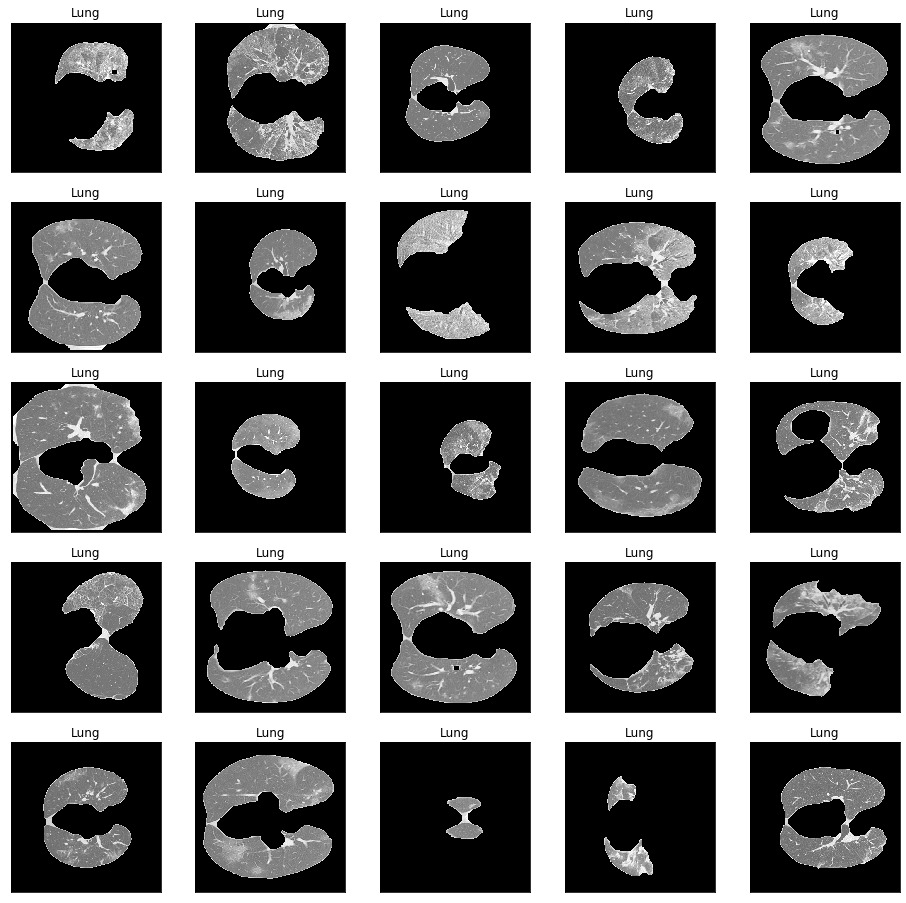

In [15]:
#showing results for train
showImages(trainSegmentedLungs[:25],5,5)
print('First 25 Segmented Lungs from Train Images')
print('######################################')

First 25 Sobel Gradient from Train Images
######################################


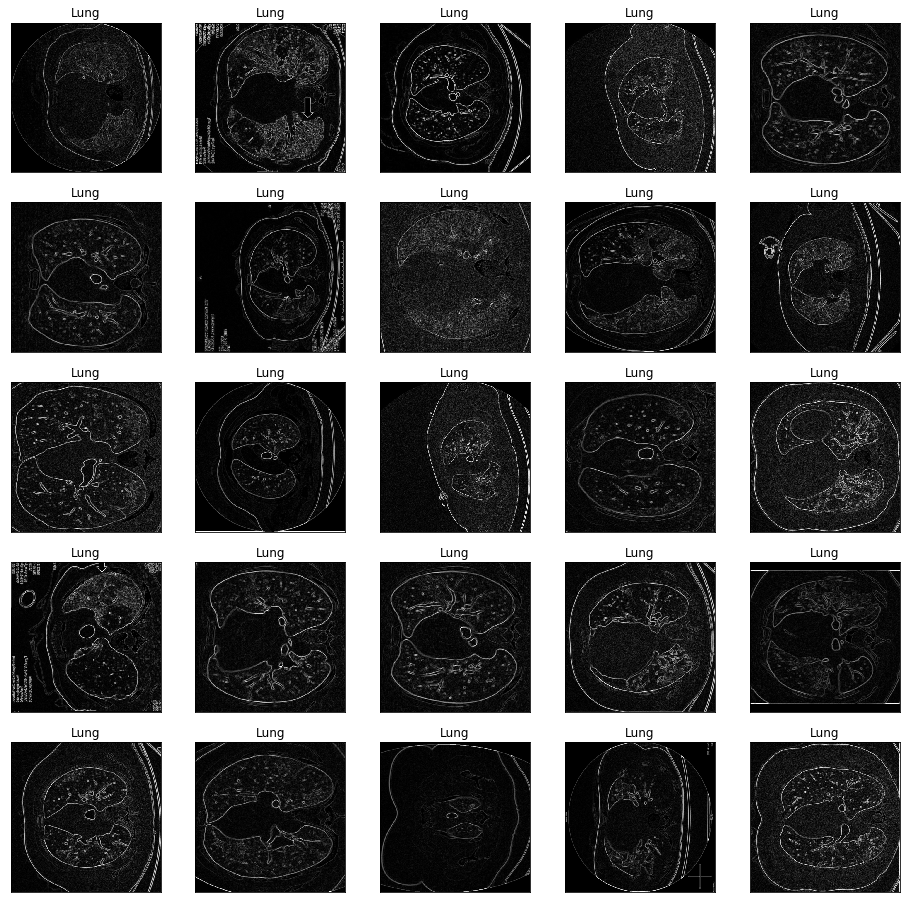

In [16]:
#showing results for train
showImages(trainSobel[:25],5,5)
print('First 25 Sobel Gradient from Train Images')
print('######################################')

All Segmented Lungs from Test Images
######################################


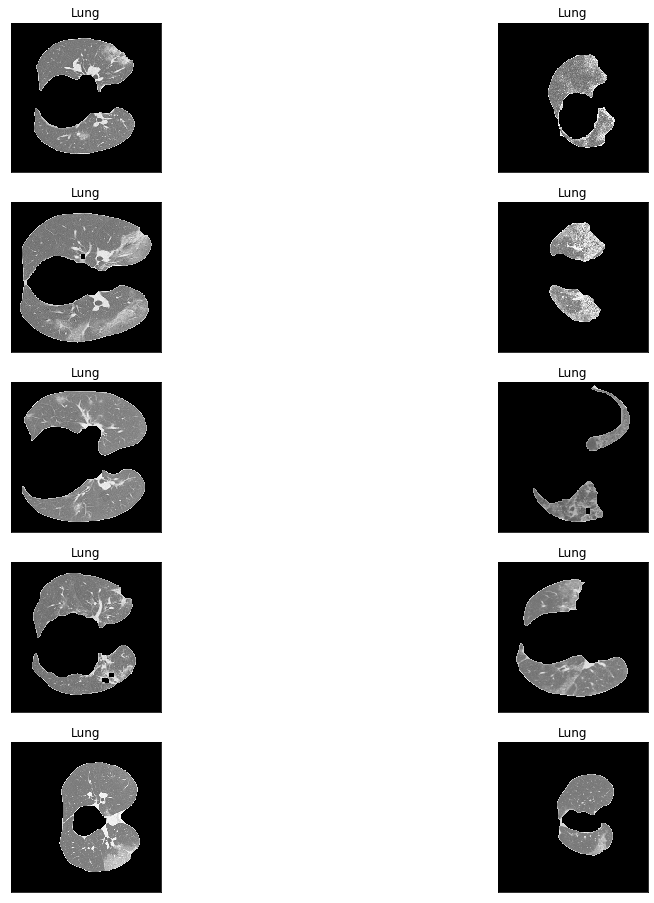

In [17]:
#showing results for test
showImages(testSegmentedLungs[:10],5,2)
print('All Segmented Lungs from Test Images')
print('######################################')

All Sobel Gradient from Train Images
######################################


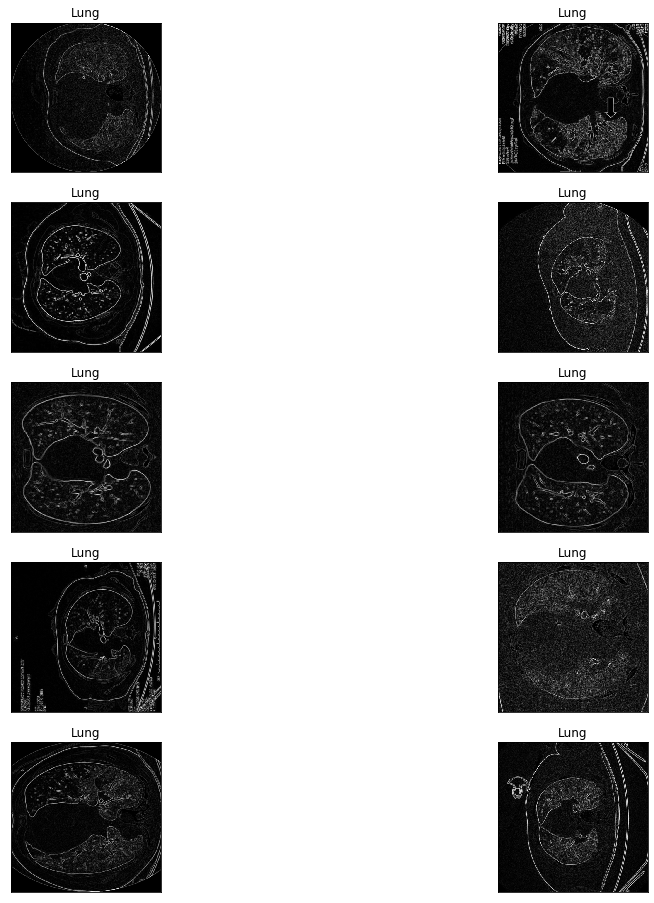

In [18]:
#showing results for test
showImages(trainSobel[:10],5,2)
print('All Sobel Gradient from Train Images')
print('######################################')

### End of the adapted code

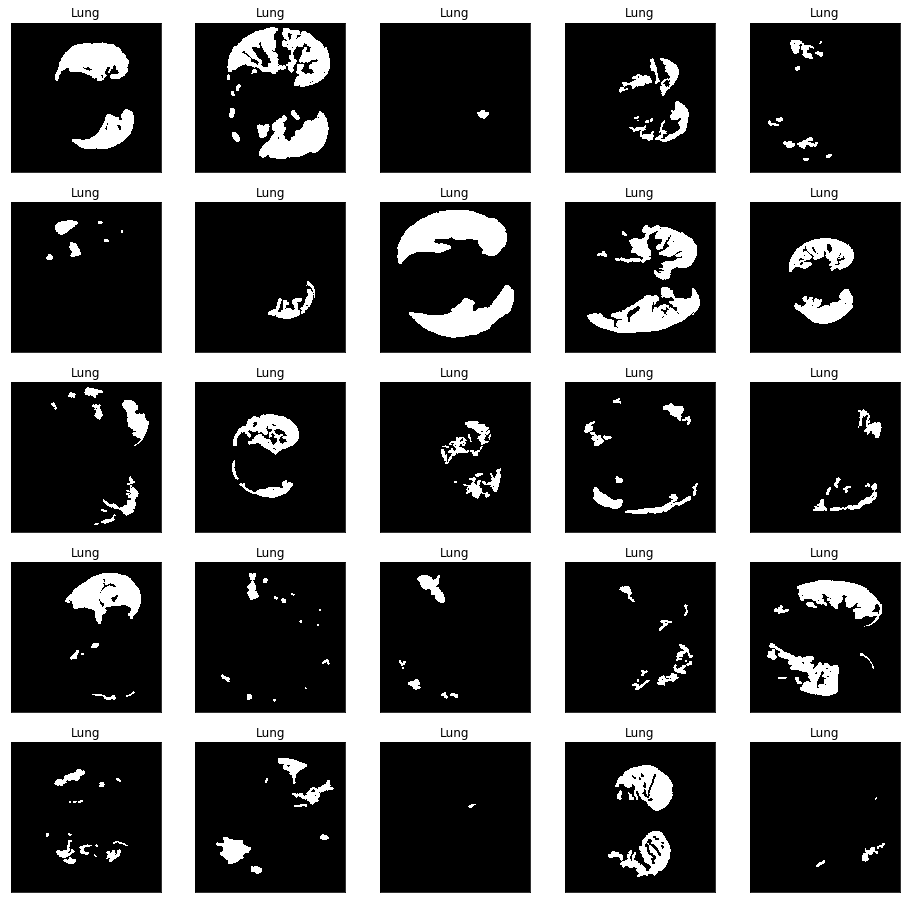

In [19]:
#we can get the values of the "healthy" zones of the lung
#using the segmentations of lungs and the mask.
masks = nib.load('tr_mask.nii.gz')
masks = getImages(masks)
#we consider type 1, type 2 and type 3 as 'sick' parts of the lung
masks[masks==2] = 1
masks[masks==3] = 1
showImages(masks[:25],5,5)

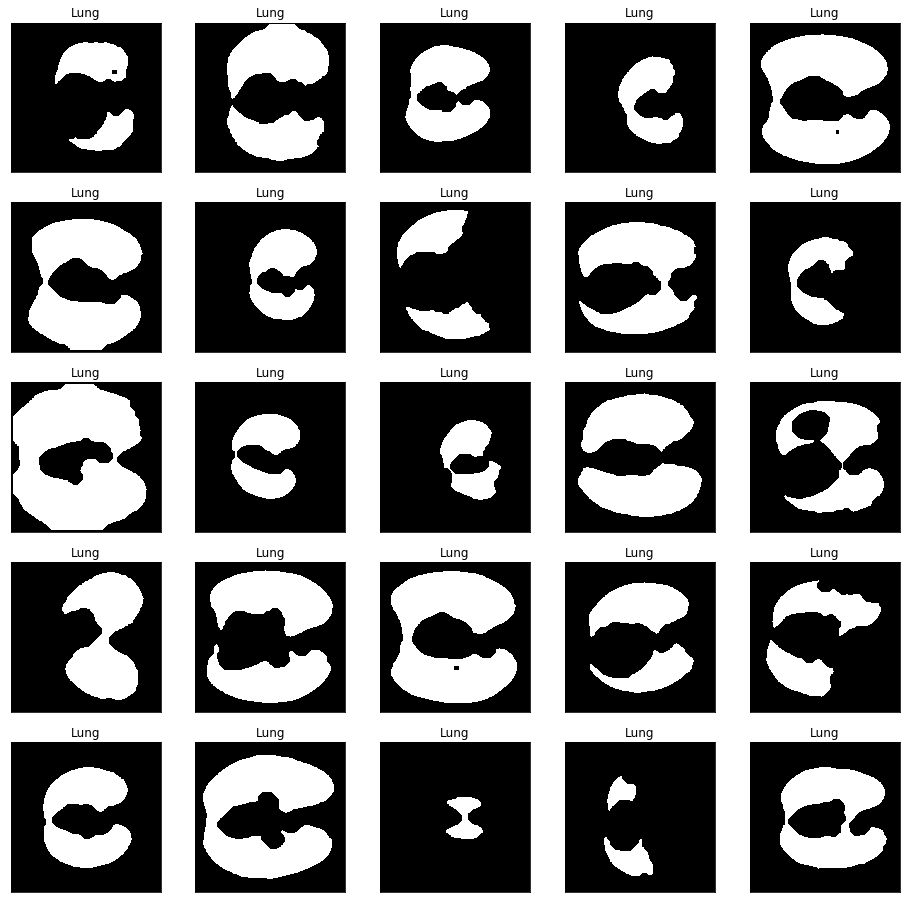

In [20]:
showImages(trainMasks[:25],5,5)

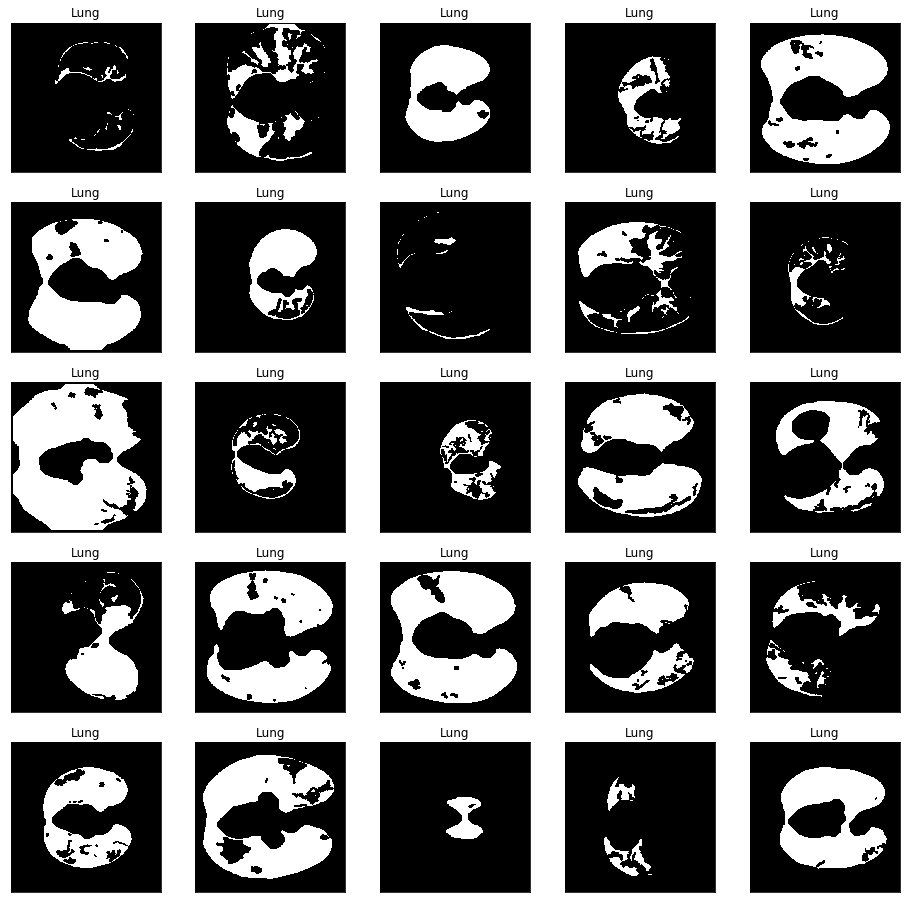

In [21]:
#make the mask for healthy lungs
substract = trainMasks - masks
substract[substract==-1] = 0
showImages(substract[:25],5,5)

In [22]:
#function to convert the space or values of the original images into a new values
#using the original values. This is like a transformation from a matrix type float to
#uint8
def convert(img, targetTypeMin, targetTypeMax, targetType):
    imin = img.min()
    imax = img.max()

    a = (targetTypeMax - targetTypeMin) / (imax - imin)
    b = targetTypeMax - a * imax
    newImg = (a * img + b).astype(targetType)
    return newImg

In [23]:
#before to obtain the mask we trasnform the original images into a new level space
transf = []
for i in range(train.shape[0]):
    transformation = convert(train[i],np.iinfo(np.uint8).min,np.iinfo(np.uint8).max,np.uint8)
    transf.append(transformation)
transf = np.array(transf)

In [24]:
#save images
for i in range(len(testSegmentedLungs)):
    transformation = convert(testSegmentedLungs[i],np.iinfo(np.uint8).min,np.iinfo(np.uint8).max,np.uint8)
    cv2.imwrite('SegmentedTest/'+str(i)+'.png', transformation)

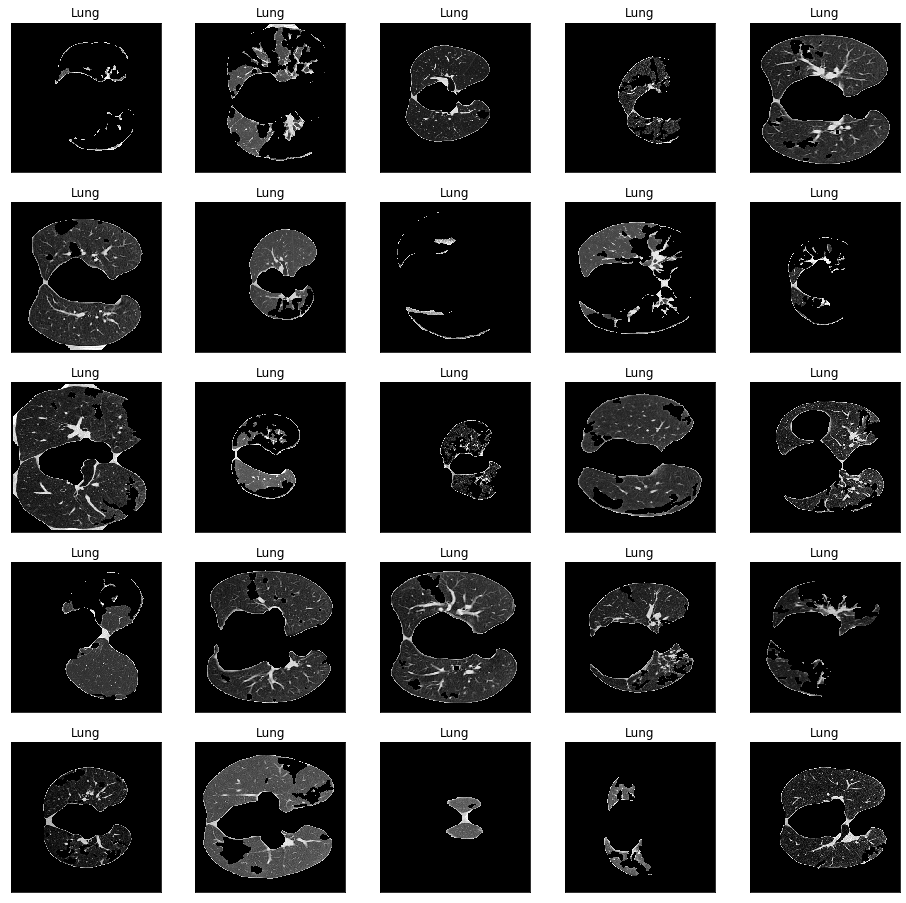

In [25]:
#make the real mask of healthy lungs and show it
healthy = np.multiply(transf,substract)
showImages(healthy[:25],5,5)

In [26]:
#function to obtain the texture propierties of each masked image using the GLCM method
from skimage.feature import greycomatrix
from skimage.feature import greycoprops
def getTextureProperties(maskedImages):
    propertyForType = np.zeros((len(maskedImages),6),dtype=float)
    for i in range(len(maskedImages)):
        GLCM = greycomatrix(maskedImages[i],distances=[1],angles=[0],symmetric=False,normed=True)
        GLCM = GLCM[1:,1:,:,:]
        contrast = greycoprops(GLCM,'contrast')
        dissimilarity = greycoprops(GLCM,'dissimilarity')
        homogeneity = greycoprops(GLCM,'homogeneity')
        asm = greycoprops(GLCM,'ASM')
        energy = greycoprops(GLCM,'energy')
        correlation = greycoprops(GLCM,'correlation')
        propertyForType[i] = (contrast,dissimilarity,homogeneity,asm,energy,correlation)
    return propertyForType

In [27]:
from sklearn import preprocessing
import pandas as pd
#transfor to uint8 and get texture properties
healthy = healthy.astype(np.uint8)
healthyLung = getTextureProperties(healthy)
#healthyLung = preprocessing.scale(healthyLung)
#create dataframes from the texture properties
healthyLungDataFrame = pd.DataFrame(healthyLung)
#saving the data into .csv file
healthyLungDataFrame.to_csv('healthy.csv',index=False,header=False)

### The following code is necesary for the notebook TrainWithLessSamples.ipynb

In [34]:
#set the indexes
rand = np.array([ 8, 70, 82, 28, 63,  0,  5, 50, 81,  4, 23, 65, 76, 60, 24, 42, 77,38, 56, 75])
#make an np array
trainSegmentedLungs = np.array(trainSegmentedLungs)
#get the images based on its indexes
utilImages = trainSegmentedLungs[rand]
#save the images
for i in range(utilImages.shape[0]):
    transformation = convert(utilImages[i],np.iinfo(np.uint8).min,np.iinfo(np.uint8).max,np.uint8)
    cv2.imwrite('TrainWith/'+str(i)+'.png', transformation)

In [32]:
#try something to understand
trainSegmentedLungs[0]
print(trainSegmentedLungs.dtype)

float64
